# Weak lensing – Notebook 28th February 2024

Notebook tested with commit nb `xxx`.

Check requirements in `env.yml` (conda virtual environment).

The `pycs` package from the `cosmostat` repository (https://github.com/CosmoStat/cosmostat) could not be installed with `pip install .`. Therefore, the path to the git repository must be added to `PYTHONPATH` (see below). Tested with commit nb `a420193ced4bcd081f04a0afe0773aa4c120bfc8` (branch "hos").

The `pysparse` package from the `Sparse2D` repository  (https://github.com/CosmoStat/Sparse2D) needs to be manually installed. Tested with commit nb `3f9d54863765980299cfe92e0624ba93ed7ff02b`.

Very dirty workaround to avoid `ImportError: libpython3.11.so.1.0: cannot open shared object file: No such file or directory`: create a symbolic link from the `libpython3.11.so.1.0` file, which is typically stored in the `~/miniconda3/envs/wl-pycs/lib` (i.e., the directory for shared libraries within the virtual environment), to a standard root location such as `/lib/x86_64-linux-gnu`.

In [1]:
# TODO: fix the issue with path to shared libraries within virtual environments

In [2]:
%matplotlib inline

import os
import sys
import yaml
import numpy as np
import matplotlib.pyplot as plt
from lenspack.utils import bin2d

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

with open('../config.yml', 'r') as file:
    config_data = yaml.safe_load(file)
pycs_dir = os.path.expanduser(config_data['pycs_dir'])
sys.path.append(pycs_dir) # tested with commit nb a420193ced4bcd081f04a0afe0773aa4c120bfc8 (branch "hos")

In [3]:
import weaklensing.utils as wlutils
import weaklensing.kappatng as wlktng
import weaklensing.cosmos as wlcosmos

import pycs.astro.wl.mass_mapping as csmm

## 2024-02-28 & 29

## Weak lensing with UQ

In [6]:
size = 1.5
width, size = wlktng.get_npixels(size)
print(f"Nb of pixels per side = {width}")
print(f"Opening angle = {size:.2f} deg")

Nb of pixels per side = 307
Opening angle = 1.50 deg


Load kappaTNG dataset

In [7]:
index_redshift = 2
ninpimgs = 40 # keep it small
kappa = wlktng.kappa_tng(index_redshift, ninpimgs, width=width)

Load data from the COSMOS catalog

In [8]:
cat_cosmos = wlcosmos.cosmos_catalog(
    include_faint=False
)
data_cosmos = wlcosmos.get_data_from_cosmos(cat_cosmos, size)
extent = data_cosmos["extent"]
cosmos_mask, ra, dec = wlcosmos.cosmos_boundaries(extent, width)

In [9]:
shapedisp1, shapedisp2 = data_cosmos["shapedisp"]
shapedisp = (shapedisp1 + shapedisp2) / 2

print(f"Shape dispersion 1 = {shapedisp1:.3f}")
print(f"Shape dispersion 2 = {shapedisp2:.3f}")

Shape dispersion 1 = 0.278
Shape dispersion 2 = 0.279


In [10]:
print(f"Resolution = {wlktng.RESOLUTION:.2f} arcmin/pixel")

Resolution = 0.29 arcmin/pixel


Map of number of galaxies per pixel

In [11]:
ngal = wlutils.ngal_per_pixel(cat_cosmos["Ra"], cat_cosmos["Dec"], width, extent)

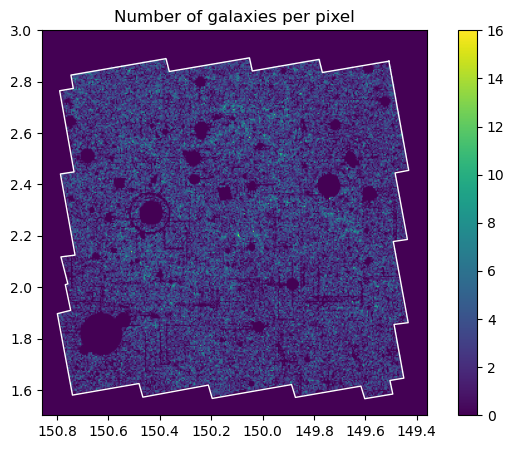

In [12]:
plt.figure(figsize=(8, 5))
plt.imshow(ngal, origin='lower', extent=extent)
plt.xlim(plt.gca().get_xlim()[::-1]) # Flip x-axis
plt.colorbar()
plt.plot(ra, dec,  c='w', lw=1)
plt.title("Number of galaxies per pixel")
plt.show()

Create noisy shear maps

In [13]:
#gamma1, gamma2 = wlutils.get_shear_from_convergence(kappa)
#gamma1_noisy, gamma2_noisy, std_noise = wlutils.get_masked_and_noisy_shear(
#    gamma1, gamma2, ngal, shapedisp
#)

In [14]:
gamma1 = bin2d(
    cat_cosmos["Ra"], cat_cosmos["Dec"], npix=width,
    v=cat_cosmos['e1iso_rot4_gr_snCal'], extent=extent
)
gamma2 = bin2d(
    cat_cosmos["Ra"], cat_cosmos["Dec"], npix=width,
    v=cat_cosmos['e2iso_rot4_gr_snCal'], extent=extent
)
gamma1 = gamma1[np.newaxis, :]
gamma2 = gamma2[np.newaxis, :]
gamma1_noisy, gamma2_noisy, std_noise = wlutils.get_masked_and_noisy_shear(
    gamma1, gamma2, ngal, shapedisp, only_mask=True
)

/home/leterme231/OneDrive/Documents/Code/weaklensing/weaklensing/utils.py:132: RuntimeWarning: divide by zero encountered in divide
  shapedisp / np.sqrt(ngal), posinf=stdnoise_mask


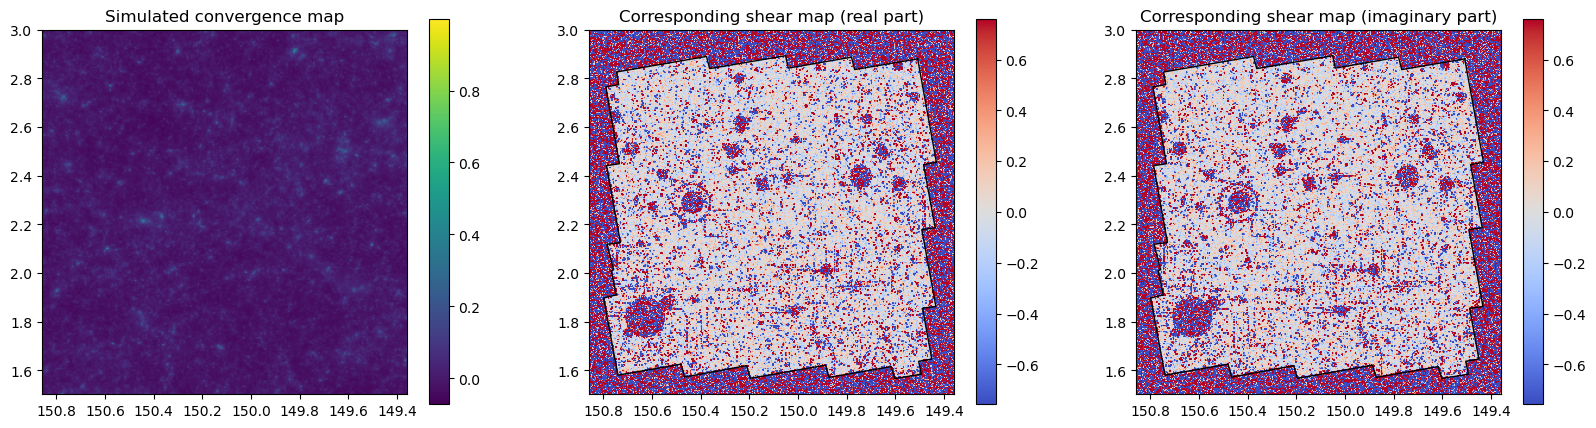

In [15]:
vmin = np.min(kappa)
vmax = np.max(kappa)
vmin_gamma = min(np.min(gamma1), np.min(gamma2))
vmax_gamma = max(np.max(gamma1), np.max(gamma2))
saturation = 0.6

plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.imshow(kappa[0], origin='lower', vmin=vmin, vmax=vmax, extent=extent)
plt.xlim(plt.gca().get_xlim()[::-1]) # Flip x-axis
plt.colorbar()
plt.title("Simulated convergence map")

plt.subplot(132)
plt.imshow(
    gamma1_noisy[0], cmap='coolwarm', origin='lower',
    vmin=-saturation*vmax_gamma, vmax=saturation*vmax_gamma, extent=extent
)
plt.xlim(plt.gca().get_xlim()[::-1]) # Flip x-axis
plt.colorbar()
plt.plot(ra, dec,  c='k', lw=1)
plt.title("Corresponding shear map (real part)")

plt.subplot(133)
plt.imshow(
    gamma2_noisy[0], cmap='coolwarm', origin='lower',
    vmin=-saturation*vmax_gamma, vmax=saturation*vmax_gamma, extent=extent
)
plt.xlim(plt.gca().get_xlim()[::-1]) # Flip x-axis
plt.colorbar()
plt.plot(ra, dec,  c='k', lw=1)
plt.title("Corresponding shear map (imaginary part)")

plt.show()

In [16]:
confidence = 2 # Level of confidence (n-sigma)
alpha = wlutils.get_alpha_from_confidence(confidence)

min_nimgs_calib = wlutils.get_min_nimgs_calib(alpha)
print(f"Confidence level of {confidence}-sigma --> alpha = {alpha:.1%}")
print(f"Smallest possible size for the calibration set = {min_nimgs_calib}")

Confidence level of 2-sigma --> alpha = 4.6%
Smallest possible size for the calibration set = 21


In [17]:
nimgs_calib = 100
nimgs = kappa.shape[0]
nimgs_test = nimgs - nimgs_calib
print(f"Size of the calibration set = {nimgs_calib}")
print(f"Size of the test set = {nimgs_test}")

Size of the calibration set = 100
Size of the test set = 260


Register data into a `csmm.shear_data` object

In [47]:
sheardata = csmm.shear_data()
sheardata.g1 = gamma1[0]
sheardata.g2 = gamma2[0]
sheardata.mask = (ngal > 0).astype(int)
sheardata.Ncov = std_noise**2 # TODO: in cosmostat/examples/sparse2d.ipynb, there's a factor 2. Why?
sheardata.nx = width
sheardata.ny = width

In [40]:
np.mean(np.abs(gamma1[gamma1 != 0]))

0.14814437950361947

Create a mass mapping structure and initialize it

In [41]:
massmap = csmm.massmap2d(name='mass')
massmap.init_massmap(width, width)
massmap.DEF_niter = 100
#massmap.Verbose = True

### Kaiser-Squires estimator

In [50]:
kappa_ks, _, _ = wlutils.ksfilter(
    sheardata.g1[np.newaxis, :], sheardata.g2[np.newaxis, :], std_noise, confidence=confidence
)
kappa_ks = kappa_ks[0] * cosmos_mask

ValueError: not enough values to unpack (expected 3, got 2)

### MLE estimator

In [43]:
from scipy import ndimage

kappa_mle, _ = massmap.prox_mse(
    sheardata.g1, sheardata.g2, sheardata.Ncov, Inpaint=False
) # inpaiting already done when creating noisy shear maps
kappa_mle = ndimage.gaussian_filter(
    kappa_ks, 2., mode="wrap"
)

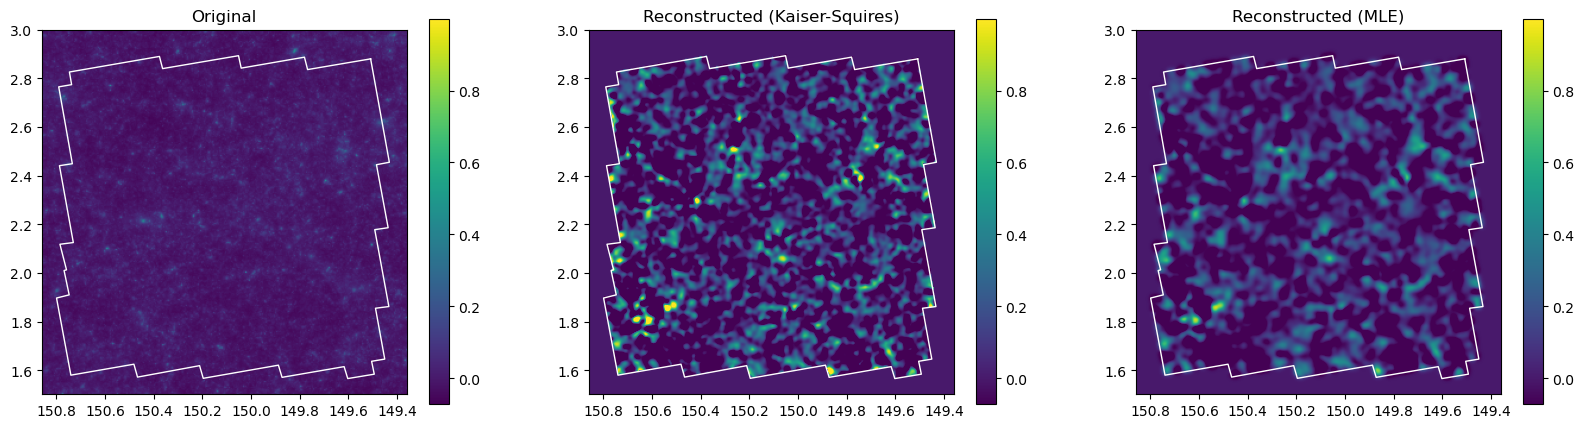

In [44]:
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.imshow(kappa[0], origin='lower', vmin=vmin, vmax=vmax, extent=extent)
plt.xlim(plt.gca().get_xlim()[::-1]) # Flip x-axis
plt.colorbar()
plt.plot(ra, dec,  c='w', lw=1)
plt.title("Original")

plt.subplot(132)
plt.imshow(kappa_ks, origin='lower', vmin=vmin, vmax=vmax, extent=extent)
plt.xlim(plt.gca().get_xlim()[::-1]) # Flip x-axis
plt.colorbar()
plt.plot(ra, dec,  c='w', lw=1)
plt.title("Reconstructed (Kaiser-Squires)")

plt.subplot(133)
plt.imshow(kappa_mle, origin='lower', vmin=vmin, vmax=vmax, extent=extent)
plt.xlim(plt.gca().get_xlim()[::-1]) # Flip x-axis
plt.colorbar()
plt.plot(ra, dec,  c='w', lw=1)
plt.title("Reconstructed (MLE)")

plt.show()

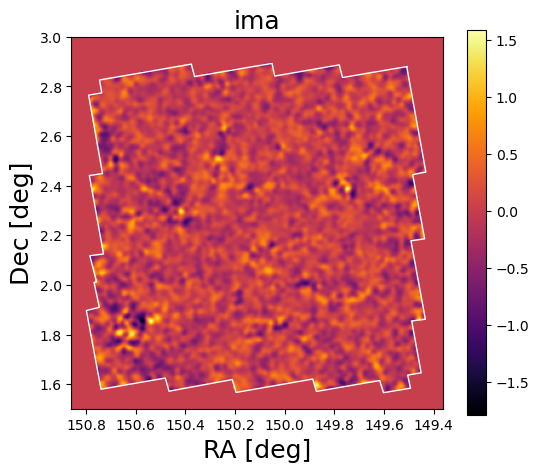

In [46]:
tvradec(kappa_ks)

### MCALens algorithm

*From J.-L. Starck, K. E. Themelis, N. Jeffrey, A. Peel, and F. Lanusse, “Weak-lensing mass reconstruction using sparsity and a Gaussian random field,” A&A, vol. 649, p. A99, May 2021.*

Compute the 1D power spectrum from simulated convergence maps

In [23]:
# Load new set of convergence maps
# (the power spectrum shouldn't be computed on the calibration or test sets)
ninpimgs_ps = 20
kappa_ps = wlktng.kappa_tng(index_redshift, ninpimgs_ps, start_idx=ninpimgs, width=width)

In [24]:
powerspectrum = np.mean(np.abs(np.fft.fft2(kappa_ps) / width)**2, axis=0) # expected value of the squared Fourier modulus
powerspectrum = powerspectrum[:width//2, :width//2] # only positive frequencies, by symmetry
powerspectrum_1d = (powerspectrum[0, :] + powerspectrum[:, 0]) / 2 # assumed isotropic
%xdel kappa_ps

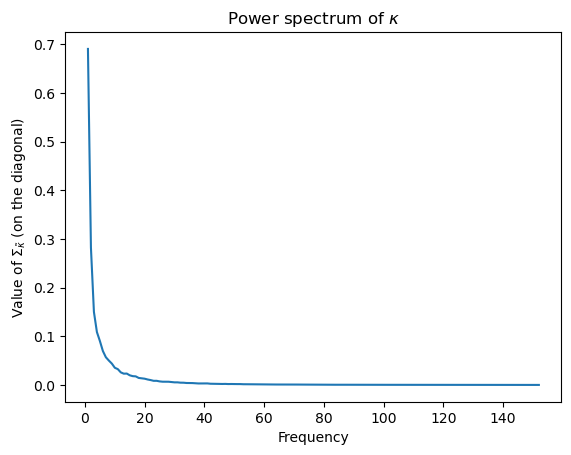

In [25]:
plt.plot(np.arange(1, width//2), powerspectrum_1d[1:])
plt.xlabel("Frequency")
plt.ylabel(r"Value of $\Sigma_\tilde{\kappa}$ (on the diagonal)")
plt.title(r"Power spectrum of $\kappa$")
plt.show()

Looks like a pink noise?

Run MCALens

In [22]:
#def myfunc():
#    kappa_mcalens_g, _, kappa_mcalens_s, _ = massmap.sparse_wiener_filtering(
#        sheardata, powerspectrum_1d, Inpaint=False
#    ) # inpaiting already done when creating noisy shear maps

In [23]:
#stats_result = %prun -s cumtime -r myfunc()

In [24]:
#import pstats

#stats_result.dump_stats('profile_results.pstats')

In [26]:
kappa_mcalens_g, _, kappa_mcalens_s, _ = massmap.sparse_wiener_filtering(
    sheardata, powerspectrum_1d, Nsigma=5, Inpaint=False
) # inpaiting already done when creating noisy shear maps

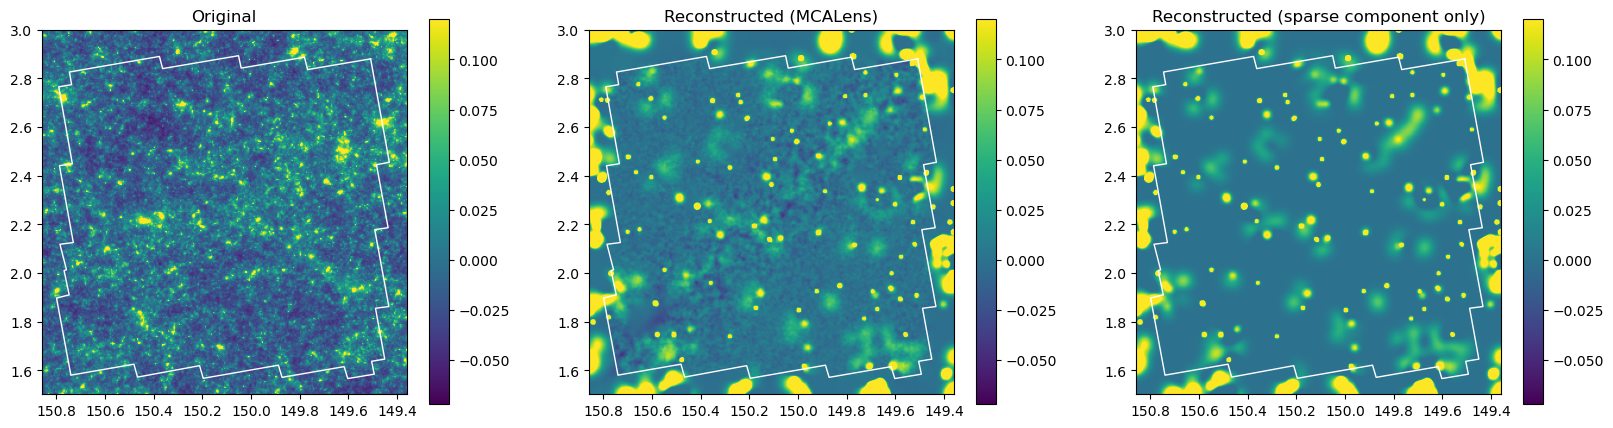

In [27]:
plt.figure(figsize=(20, 5))

plt.subplot(131)
#plt.imshow(kappa[0], origin='lower', vmin=vmin, vmax=vmax, extent=extent)
plt.imshow(kappa[0], origin='lower', vmin=vmin, vmax=0.12, extent=extent)
plt.xlim(plt.gca().get_xlim()[::-1]) # Flip x-axis
plt.colorbar()
plt.plot(ra, dec,  c='w', lw=1)
plt.title("Original")

plt.subplot(132)
#plt.imshow(kappa_mcalens_g, origin='lower', vmin=vmin, vmax=vmax, extent=extent)
plt.imshow(kappa_mcalens_g, origin='lower', vmin=vmin, vmax=0.12, extent=extent)
plt.xlim(plt.gca().get_xlim()[::-1]) # Flip x-axis
plt.colorbar()
plt.plot(ra, dec,  c='w', lw=1)
plt.title("Reconstructed (MCALens)")

plt.subplot(133)
#plt.imshow(kappa_mcalens_s, origin='lower', vmin=vmin, vmax=vmax, extent=extent)
plt.imshow(kappa_mcalens_s, origin='lower', vmin=vmin, vmax=0.12, extent=extent)
plt.xlim(plt.gca().get_xlim()[::-1]) # Flip x-axis
plt.colorbar()
plt.plot(ra, dec,  c='w', lw=1)
plt.title("Reconstructed (sparse component only)")

plt.show()

In [28]:
def tvradec(ima, title='ima',vmin=None,vmax=None,smooth=None,xclus=False,mtext=False,m500min=0, zmin=0.3,zmax=1,ztext=False,lut='inferno',filename=None,extent_radec=None):
    if extent_radec is None:
        extent_radec = extent

    fs = 18 # fontsize        
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    # Kappa map
    if smooth is None:
        imaS = ima
    else:
        imaS = gf(ima, smooth)
    img = ax.imshow(imaS, origin='lower', cmap=lut, vmin=vmin, vmax=vmax, extent=extent_radec)
    plt.plot(ra, dec,  c='w', lw=1)
    
    # Xray clusters
    if xclus:
        xclusters = np.loadtxt("mcalens_paper/xray.txt")
        highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)
        for cluster in xclusters[highz]:
            ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
            m500 = cluster[7]
            if m500 > m500min:
                ax.scatter(ra_cl, dec_cl, c='w', s=12)
                if ztext:
                    ax.text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=8, c='w')
                if mtext:
                    ax.text(ra_cl + 0.03, dec_cl - 0.02, "{:.2f}".format(m500), fontsize=8, c='w')

    # Clean up and decorate
    ax.set_aspect('equal')
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_title(title, fontsize=fs)
    ax.set_xlabel("RA [deg]", fontsize=fs)
    ax.set_ylabel("Dec [deg]", fontsize=fs)
    fig.colorbar(img, ax=ax)
    if filename is not None:
        plt.savefig(filename)
    plt.show()

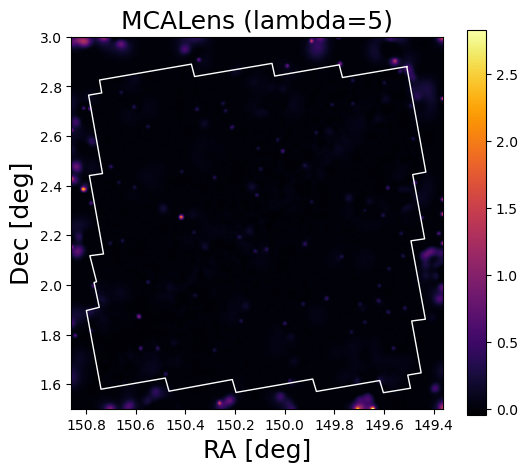

In [29]:
tvradec(kappa_mcalens_g, title='MCALens (lambda=5)')

Kaiser-Squires inversion

In [14]:
kappa_ks, kappa_ks_lo, kappa_ks_hi = wlutils.ksfilter(
    gamma1_noisy, gamma2_noisy, std_noise, confidence
)

Split test and calibration sets

In [15]:
[kappa_ks_lo_calib, kappa_ks_hi_calib, kappa_calib], [kappa_ks_lo_test, kappa_ks_hi_test, kappa_test] = \
    wlutils.split_test_calib(
        [kappa_ks_lo, kappa_ks_hi, kappa], nimgs_calib
    )
print(f"Size of the calibration set = {kappa_calib.shape[0]}")
print(f"Size of the test set = {kappa_test.shape[0]}")

Size of the calibration set = 3
Size of the test set = 177


Conformalize

In [16]:
kappa_ks_lo_cqr_test, kappa_ks_hi_cqr_test, quantile_vals, adjusted_quantile = wlutils.conformalize(
    kappa_ks_lo_test, kappa_ks_hi_test, kappa_ks_lo_calib, kappa_ks_hi_calib,
    kappa_calib, alpha
)

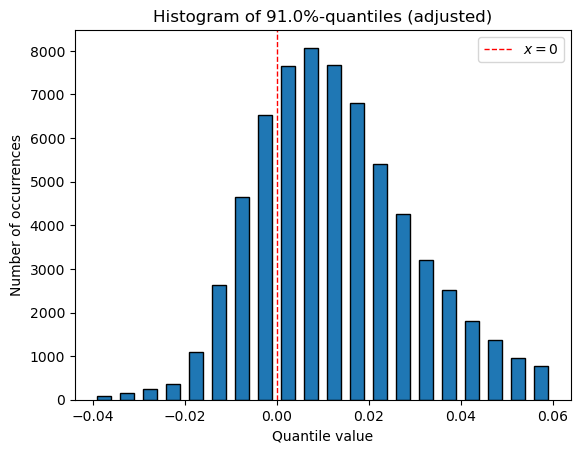

In [17]:
quantile_vals_filtered = quantile_vals[cosmos_mask] # we only consider the quantiles inside of the COSMOS field boundaries
qmin, qmax = -0.04, 0.06
nbins = 20
bins = np.linspace(qmin, qmax, nbins+1)
plt.hist(
    quantile_vals_filtered, bins=bins, edgecolor='black', align='mid', rwidth=0.6
)
plt.axvline(x=0, color='red', linestyle='dashed', linewidth=1., label=r'$x = 0$')
plt.xlabel('Quantile value')
plt.ylabel('Number of occurrences')
plt.legend()
plt.title(f'Histogram of {adjusted_quantile:.1%}-quantiles (adjusted)')
plt.show()

Get results on the test set

In [18]:
losses_ks_test = wlutils.loss(
    kappa_ks_lo_test, kappa_ks_hi_test, kappa_test, mask=cosmos_mask
)
losses_ks_cqr_test = wlutils.loss(
    kappa_ks_lo_cqr_test, kappa_ks_hi_cqr_test, kappa_test, mask=cosmos_mask
)
lower_bound_proba, upper_bound_proba = wlutils.get_bounds_proba_cqr(
    alpha, nimgs_calib
)
mid_proba = (upper_bound_proba + lower_bound_proba) / 2
mean_loss = np.mean(losses_ks_cqr_test)

print(f"Lower bound proba = {lower_bound_proba:.1e}")
print(f"Upper bound proba = {upper_bound_proba:.1e}")
print(f"Empirical mean loss (after calibration) = {mean_loss:.1e}")

Lower bound proba = 6.7e-02
Upper bound proba = 3.2e-01
Empirical mean loss (after calibration) = 2.8e-01


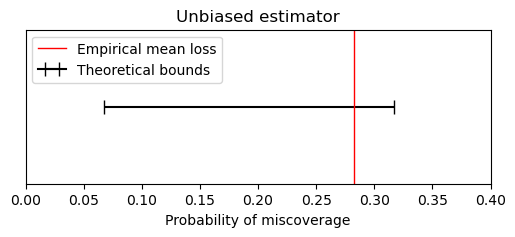

In [19]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.errorbar(
    mid_proba, 0, xerr=[[mid_proba - lower_bound_proba], [upper_bound_proba - mid_proba]],
    fmt='', color='black', capsize=5, label="Theoretical bounds"
)
ax.axvline(
    x=mean_loss, color='red', linestyle='solid', linewidth=1., label='Empirical mean loss'
)
ax.set_xlim(0., np.ceil(upper_bound_proba * 10) / 10)
ax.set_xlabel('Probability of miscoverage')
ax.set_yticks([])
plt.legend()
plt.title("Unbiased estimator")
plt.show()

Possibly very conservative.

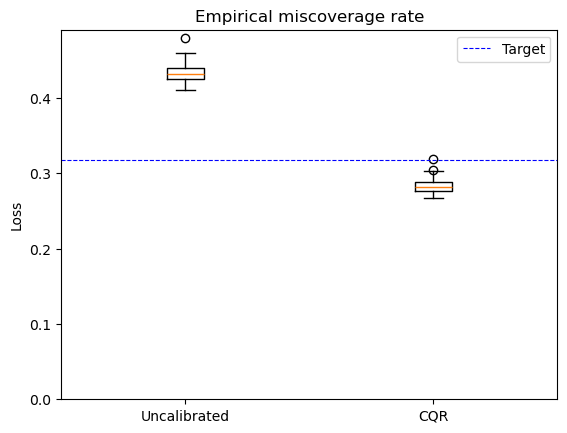

In [20]:
xticklabels = ["Uncalibrated", "CQR"]

plt.boxplot([losses_ks_test, losses_ks_cqr_test])
plt.ylim(bottom=0.)
plt.xticks([1, 2], xticklabels)
plt.ylabel("Loss")
plt.axhline(y=alpha, color='blue', linestyle='--', linewidth=0.8, label='Target')
plt.legend()
plt.title(r"Empirical miscoverage rate")
plt.show()

## 2024-02-19

To test the sensitivity of the results with respect to the calibration set, I will run the calibration several times with various test/calibration set splits. This time, I will consider each pixel as its own regression problem, and compute, for each test/calibration set split and each pixel, the error rate. Then, I will compute the empirical estimate of the statistical series $\{E_k\}_{k \in \{1,\, \dots,\, K\}}$ over the test set, with
$$
    E_k := \mathbb P\left\{
        \boldsymbol\kappa[k] \notin \left[
            \hat{\boldsymbol\kappa}^-[k],\, \hat{\boldsymbol\kappa}^+[k]
        \right] \middle| \left\{\hat{\boldsymbol\gamma}_i,\,\boldsymbol\kappa_i\right\}_{i \in \{1,\, \dots,\, n\}}
    \right\},
$$
where $\left\{\hat{\boldsymbol\gamma}_i,\,\boldsymbol\kappa_i\right\}_{i \in \{1,\, \dots,\, n\}}$ denotes a calibration set. The theory states that $\mathbb E[E_k] \in \left[\alpha - \frac1{n+1},\, \alpha\right]$, but $E_k$ may lie outside this interval, depending on the choice of calibration set.

In [21]:
ntries = 10
idx_arr = np.arange(kappa.shape[0])
list_of_errorrates = []
for i in range(ntries):
    np.random.shuffle(idx_arr)
    kappa_ks_lo_shuff = kappa_ks_lo[idx_arr]
    kappa_ks_hi_shuff = kappa_ks_hi[idx_arr]
    kappa_shuff = kappa[idx_arr]

    # Split
    [kappa_ks_lo_shuff_calib, kappa_ks_hi_shuff_calib, kappa_shuff_calib], \
        [kappa_ks_lo_shuff_test, kappa_ks_hi_shuff_test, kappa_shuff_test] = \
            wlutils.split_test_calib(
                [kappa_ks_lo_shuff, kappa_ks_hi_shuff, kappa_shuff], nimgs_calib
            )

    # Conformalize
    kappa_ks_lo_cqr_shuff_test, kappa_ks_hi_cqr_shuff_test, _, _ = wlutils.conformalize(
        kappa_ks_lo_shuff_test, kappa_ks_hi_shuff_test, kappa_ks_lo_shuff_calib, kappa_ks_hi_shuff_calib,
        kappa_shuff_calib, alpha
    )

    # Get results on the test set
    illpredicted_ks_cqr_shuff_test = (kappa_shuff_test < kappa_ks_lo_cqr_shuff_test) | \
        (kappa_shuff_test > kappa_ks_hi_cqr_shuff_test)
    errorrates = np.mean(illpredicted_ks_cqr_shuff_test, axis=0)
    errorrates = errorrates[cosmos_mask]
    list_of_errorrates.append(errorrates)

errorrates = np.array(list_of_errorrates)
mean_errorrates = np.mean(errorrates, axis=1)

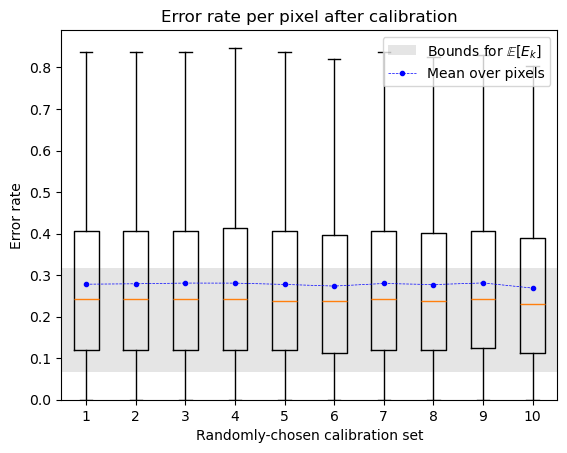

In [22]:
xticks = np.arange(ntries) + 1

plt.axhspan(
    alpha - 1 / (nimgs_calib + 1), alpha,
    color='k', alpha=0.1, linewidth=0., label=r"Bounds for $\mathbb{E}[E_k]$"
)
plt.boxplot(list_of_errorrates, showfliers=False)
plt.plot(xticks, mean_errorrates, 'b.--', linewidth=0.5, label="Mean over pixels")
plt.ylim(bottom=0.)
plt.xticks(xticks, xticks)
plt.xlabel("Randomly-chosen calibration set")
plt.ylabel("Error rate")
plt.legend(loc="upper right")
plt.title(r"Error rate per pixel after calibration")
plt.show()

We can see that, even with a small calibration set, the mean error rate remains within the theoretical bounds (rather closer to the upper bound than the lower bound). This is due to the large number of pixels over which we average the results. However, the expected error rate $\mathbb{E}[E_k]$ for a given pixel $k$ may lie below or above these bounds, as evidenced by the distribution of empirical estimates computed over the test set. Let's focus on a single (central) pixel.

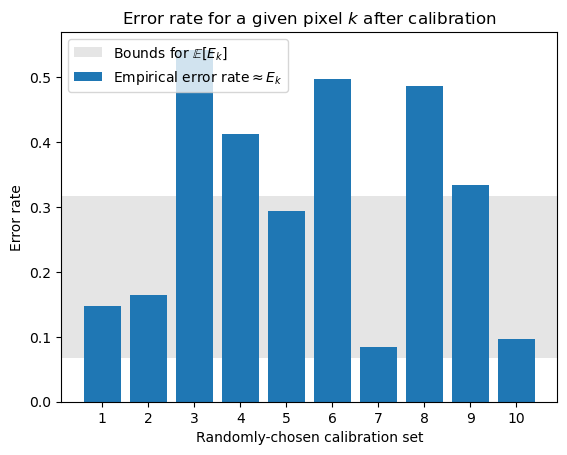

In [23]:
plt.axhspan(
    alpha - 1 / (nimgs_calib + 1), alpha,
    color='k', alpha=0.1, linewidth=0., label=r"Bounds for $\mathbb{E}[E_k]$"
)
plt.bar(xticks, errorrates[:, width * 180 + 180], label=r"Empirical error rate$\approx E_k$")
plt.ylim(bottom=0.)
plt.xticks(xticks, xticks)
plt.xlabel("Randomly-chosen calibration set")
plt.ylabel("Error rate")
plt.title(r"Error rate for a given pixel $k$ after calibration")
plt.legend()
plt.show()

The distribution of error rates per pixel has a quite large variance (which depends on the size of the calibration set), but the distribution of the mean value over a bunch of pixels is much smaller.
- [ ] **Q.** *(2024-02-19)* Is it possible to estimate this variance? We have to take into consideration the fact that the error rates $E_k$ are not independent between neighboring pixels.